In [1]:
import pandas as pd
import seaborn as sns
import pystan
import igraph
from igraph import Graph
from scipy.stats import pearsonr
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def d_min(g, n):
    try:
        return min(g.outdegree(g.predecessors(n)))
    except ValueError: #There were no predecessors, so we take the min of an empty list, which fails
        return 0
d_min = vectorize(d_min)

from scipy.stats import skew
def d_stats(g):
    d_mins = d_min(g,range(g.vcount()))
#     d_mins = d_mins[~isnan(d_mins)]
    return max(d_mins), mean(d_mins), std(d_mins), skew(d_mins)
        
def sample_bottlenecks_and_variance(n_nodes=100,
                                    p=.1,
                                    n_iterations=100):
    max_d_mins = empty(n_iterations)
    var_d_mins = empty(n_iterations)

    for i in range(n_iterations):
        g = Graph.Erdos_Renyi(n_nodes, p, directed=True)
        d_mins = d_min(g,range(g.vcount()))
        max_d_mins[i] = max(d_mins)
        var_d_mins[i] = var(d_mins)
    return max_d_mins, var_d_mins

100 0.046
100 0.092
1000 0.007
1000 0.014


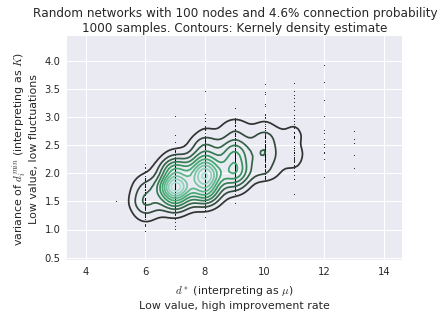

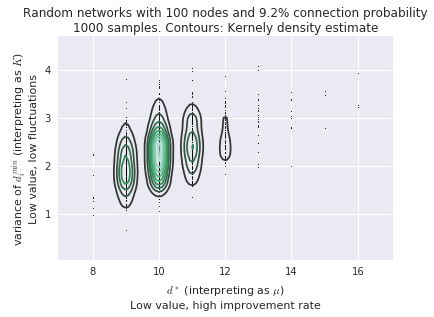

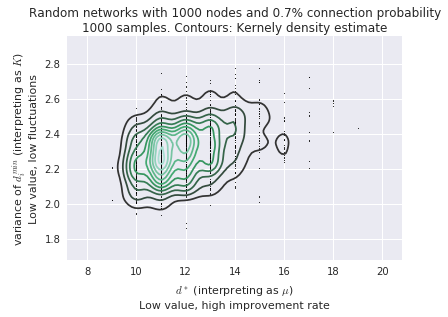

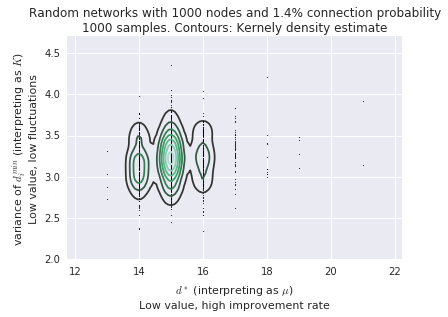

In [3]:
n_iterations = 1000

for n_nodes in [100,1000]:
    for p in [round(log(n_nodes)/n_nodes, 3),
              round(2*(log(n_nodes)/n_nodes), 3)]:
        print(n_nodes, p)
        max_d_mins, var_d_mins = sample_bottlenecks_and_variance(n_nodes=n_nodes, p=p, n_iterations=n_iterations)
        figure()
        sns.kdeplot(max_d_mins, var_d_mins)
        xlabel(r'$d^*$ (interpreting as $\mu$)'+'\nLow value, high improvement rate')
        ylabel(r'variance of $d_{i}^{min}$ (interpreting as $K$)'+'\nLow value, low fluctuations')
        scatter(max_d_mins, var_d_mins, color='k', s=.5, label='Samples')
        title('Random networks with %i nodes and %.1f%% connection probability'
              '\n%i samples. Contours: Kernely density estimate'%(n_nodes, p*100, n_iterations))

In [80]:
def dsm_improvement(g,n_attempts=1000, costs=None, components=False):
    
    if costs is None:
        costs = rand_cost(g.vcount())
    else:
        costs = costs.copy()

    if components:
        costs = tile(costs,(n_attempts,1))
    
    total_cost_series = empty(n_attempts)
    
    for t in range(n_attempts):
        i = randint(g.vcount())
        j = g.successors(i)
        new_cost = rand_cost(g.outdegree(i))
        
        if components:
            old_cost = costs[t,j]
        else:
            old_cost = costs[j]
            
        if sum(new_cost)<sum(old_cost):
            if components:
                costs[t:,j] = new_cost
            else:
                costs[j] = new_cost
                
        if components:
            total_cost_series[t] = sum(costs[t])
        else:
            total_cost_series[t] = sum(costs)

    if components:
        return costs
    else:
        return total_cost_series

def dsm_components_improvement(g,n_attempts=1000):
    costs = rand_cost(g.vcount())
    costs = tile(costs,(n_attempts,1))
        
    for t in range(n_attempts):
        i = randint(g.vcount())
        j = g.successors(i)
        new_cost = rand_cost(g.outdegree(i))
        old_cost = costs[t,j]
        if sum(new_cost)<sum(old_cost):
            costs[t:,j] = new_cost
    return costs

def rand_cost(n=1,gamma=1, lower_limit=0, upper_limit=1):
    # p(cost) ~ cost^(gamma-1).  Calculated by using the CDF p(cost<x) ~ x^gamma
    return (lower_limit**(gamma)+rand(n)*(upper_limit**(gamma)-lower_limit**(gamma)))**(1/(gamma))

# def attempt_time_series(beta=1, time_steps=40):
#     return exp(beta*arange(time_steps))

def expspace_ind(y, time_series_length=40):
    return unique(around(logspace(0,log10(len(y)),time_series_length))).astype('int')-1

In [42]:
g = Graph.Erdos_Renyi(10, .1, directed=True)

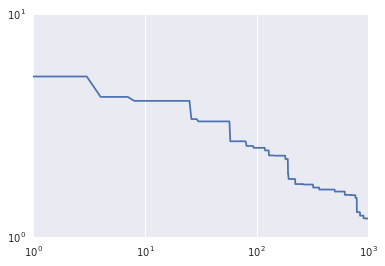

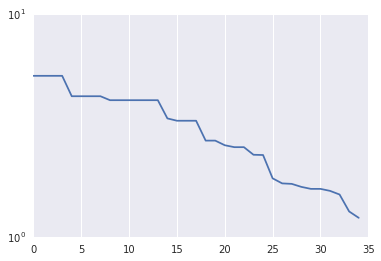

In [43]:
y = dsm_improvement(g)

plot(y)
yscale('log')
xscale('log')

figure()
time_series_length = 40
ind = expspace_ind(y)
plot(y[ind])
yscale('log')

(1000, 10)


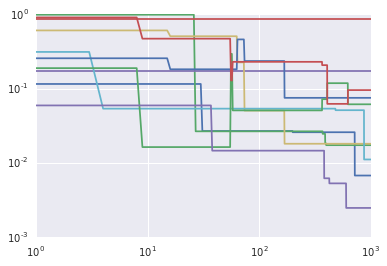

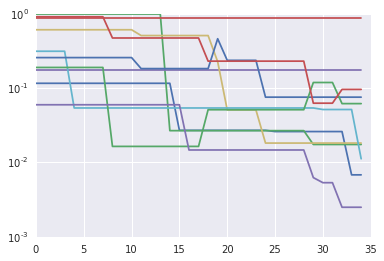

In [33]:
y = dsm_improvement(g,components=True)
print(shape(y))
plot(y)
yscale('log')
xscale('log')

figure()
time_series_length = 40
ind = expspace_ind(y)
plot(y[ind])
yscale('log')

In [9]:
arma_model_code ="""
data { 
  int<lower=1> T; 
  real y[T];
}

parameters { 
  real mu; 
  real<lower=-1,upper=1> theta; 
  real<lower=0> sigma; 
} 

transformed parameters {
real K;
K = sqrt( (1+theta^2) * sigma^2 );
}

model {
  vector[T] nu;
  vector[T] err;
  nu[1] = mu + mu;
  err[1] = y[1] - nu[1];
  for (t in 2:T) {
    nu[t] = mu  + theta * err[t-1];
    err[t] = y[t] - nu[t];
  }
  mu ~ normal(0, 1);
  theta ~ normal(0, 1);
  sigma ~ student_t(4, 0, 2);
  err ~ normal(0, sigma);
}
"""
arma_model = pystan.StanModel(model_code=arma_model_code)

In [10]:
arma_onesided_noise_model_code ="""
data { 
  int<lower=1> T; 
  real y[T];
}

parameters { 
  real mu; 
  real<lower=-1,upper=1> theta; 
  real<lower=0> sigma; 
} 

model {
  vector[T] nu;
  vector[T] err;
  nu[1] = mu + mu;
  err[1] = abs(y[1] - nu[1]);
  for (t in 2:T) {
    nu[t] = mu  + theta * abs(err[t-1]);
    err[t] = y[t] - nu[t];
  }
  mu ~ normal(0, 1);
  theta ~ normal(0, 1);
  sigma ~ student_t(4, 0, 2);
  err ~ normal(0, sigma);
}
"""

arma_onesided_noise_model = pystan.StanModel(model_code=arma_onesided_noise_model_code)

In [11]:
arma_onesided_noise_no_autocorrelation_model_code ="""
data { 
  int<lower=1> T; 
  real y[T];
}

parameters { 
  real mu; 
  real<lower=0> sigma; 
} 

model {
  vector[T] nu;
  vector[T] err;
  nu[1] = mu + mu;
  err[1] = abs(y[1] - nu[1]);
  for (t in 2:T) {
    nu[t] = mu;
    err[t] = y[t] - nu[t];
  }
  mu ~ normal(0, 1);
  sigma ~ student_t(4, 0, 2);
  err ~ normal(0, sigma);
}
"""
arma_onesided_noise_no_autocorrelation_model = pystan.StanModel(model_code=arma_onesided_noise_no_autocorrelation_model_code)

10 0.23
10 0.461
100 0.046
100 0.092
1000 0.007
1000 0.014


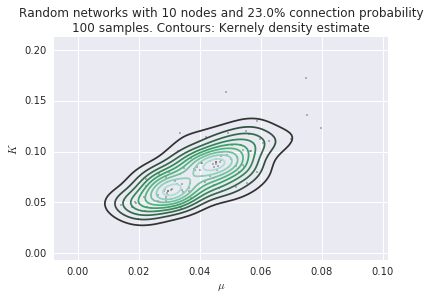

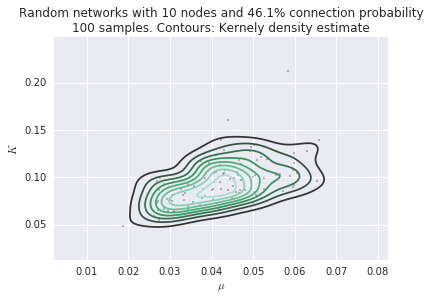

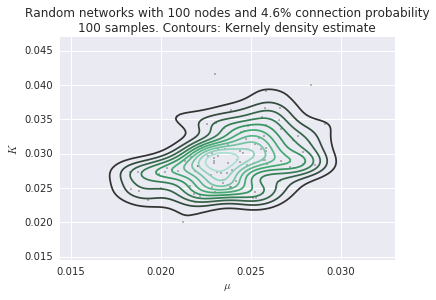

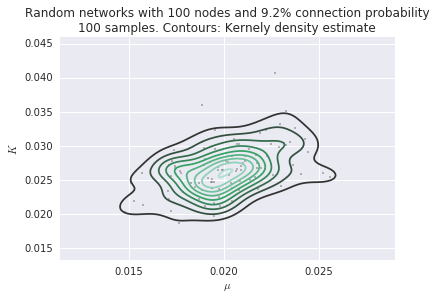

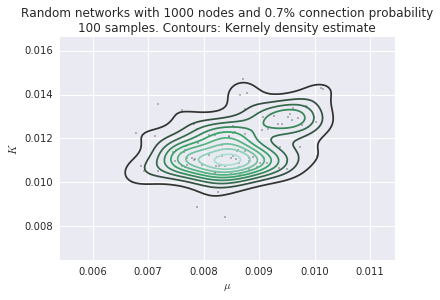

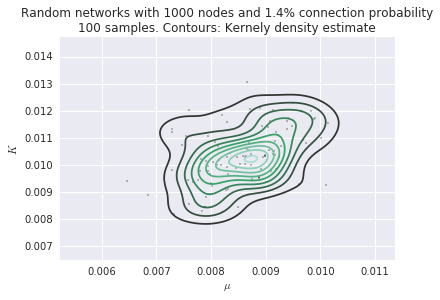

In [19]:
#### Using the possibly misspecified model of noise in both directions (is that actually a mispecification?) and autocorrelation (is that?)  
def sample_mu_and_K_system(n_nodes=100,
                    p=.1,
                    n_iterations=1):
    mus = empty(n_iterations)
    Ks = empty(n_iterations)

    from igraph import Graph
    for i in range(n_iterations):
        g = Graph.Erdos_Renyi(n_nodes, p, directed=True)
        y = dsm_improvement(g)
        y = y[expspace_ind(y)]
        data = {'y':-diff(log(y)),
                'T':len(y)-1}
        fit = arma_model.sampling(data=data)
        mus[i] = fit['mu'].mean()
        Ks[i] = fit['K'].mean()
    return mus, Ks

n_iterations = 100

for n_nodes in [10,100,1000]:
    for p in [round(log(n_nodes)/n_nodes, 3),
              round(2*(log(n_nodes)/n_nodes), 3)]:
        print(n_nodes, p)
        mus, Ks = sample_mu_and_K_system(n_nodes=n_nodes, p=p, n_iterations=n_iterations)
        figure()
        sns.kdeplot(mus, Ks)
        xlabel(r'$\mu$')
        ylabel(r'$K$')
        scatter(mus, Ks, color='k', s=.5, label='Samples')
        title('Random networks with %i nodes and %.1f%% connection probability'
              '\n%i samples. Contours: Kernely density estimate'%(n_nodes, p*100, n_iterations))

10 0.23
10 0.461
100 0.046
100 0.092
1000 0.007
1000 0.014


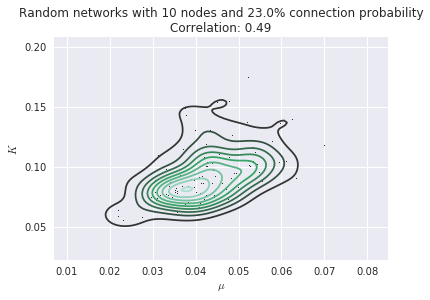

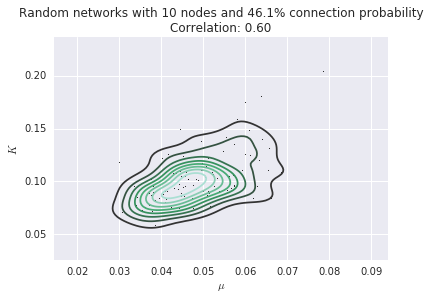

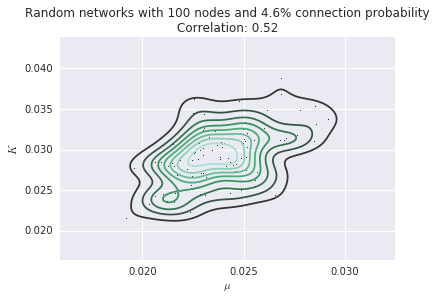

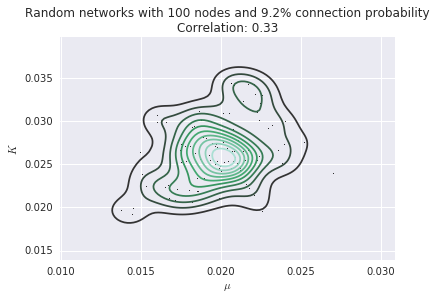

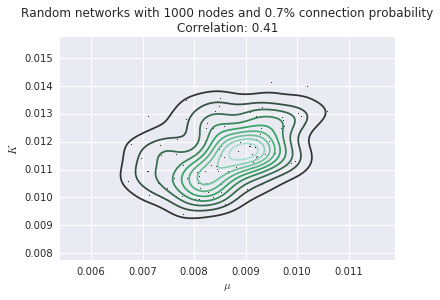

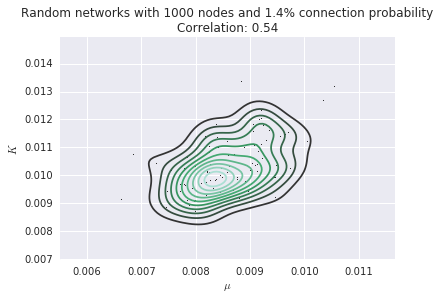

In [47]:
#### Using the possibly misspecified model of noise in both directions (is that actually a mispecification?) and autocorrelation (is that?) 
#### Using the same DSM each time 
def sample_mu_and_K_system(n_nodes=100,
                    p=.1,
                    n_iterations=1):
    mus = empty(n_iterations)
    Ks = empty(n_iterations)

    from igraph import Graph
    g = Graph.Erdos_Renyi(n_nodes, p, directed=True)

    for i in range(n_iterations):
        y = dsm_improvement(g)
        y = y[expspace_ind(y)]
        data = {'y':-diff(log(y)),
                'T':len(y)-1}
        fit = arma_model.sampling(data=data)
        mus[i] = fit['mu'].mean()
        Ks[i] = fit['K'].mean()
    return mus, Ks

n_iterations = 100

for n_nodes in [10,100,1000]:
    for p in [round(log(n_nodes)/n_nodes, 3),
              round(2*(log(n_nodes)/n_nodes), 3)]:
        print(n_nodes, p)
        mus, Ks = sample_mu_and_K_system(n_nodes=n_nodes, p=p, n_iterations=n_iterations)
        figure()
        sns.kdeplot(mus, Ks)
        xlabel(r'$\mu$')
        ylabel(r'$K$')
        scatter(mus, Ks, color='k', s=.5, label='Samples')
        title('Random networks with %i nodes and %.1f%% connection probability'
              '\nCorrelation: %.2f'%(n_nodes, p*100, pearsonr(mus,Ks)[0]))

10 0.23
10 0.461
100 0.046
100 0.092
1000 0.007
1000 0.014


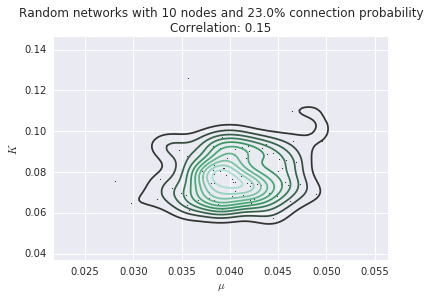

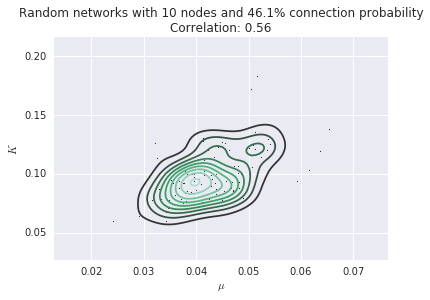

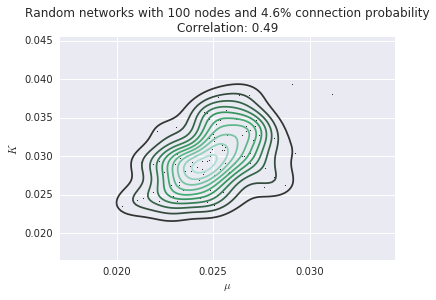

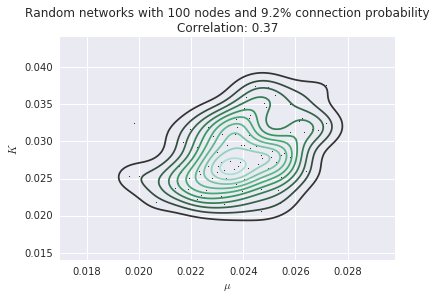

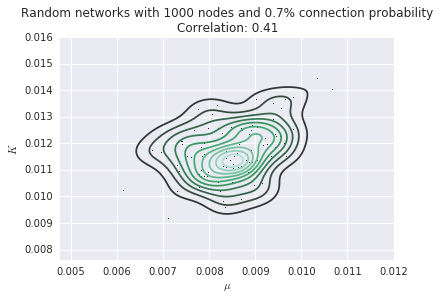

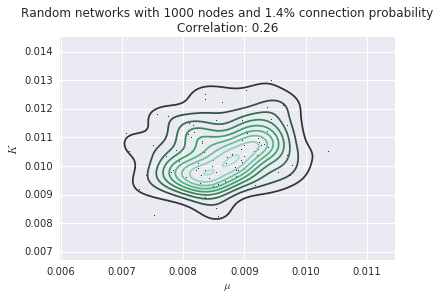

In [91]:
#### Using the possibly misspecified model of noise in both directions (is that actually a mispecification?) and autocorrelation (is that?) 
#### Using the same DSM each time 
def sample_mu_and_K_system(n_nodes=100,
                    p=.1,
                    n_iterations=1):
    mus = empty(n_iterations)
    Ks = empty(n_iterations)

    from igraph import Graph
    g = Graph.Erdos_Renyi(n_nodes, p, directed=True)
    costs = rand_cost(g.vcount())

    for i in range(n_iterations):
        y = dsm_improvement(g,costs=costs)
        y = y[expspace_ind(y)]
        data = {'y':-diff(log(y)),
                'T':len(y)-1}
        fit = arma_model.sampling(data=data)
        mus[i] = fit['mu'].mean()
        Ks[i] = fit['K'].mean()
    return mus, Ks

n_iterations = 100

for n_nodes in [10,100,1000]:
    for p in [round(log(n_nodes)/n_nodes, 3),
              round(2*(log(n_nodes)/n_nodes), 3)]:
        print(n_nodes, p)
        mus, Ks = sample_mu_and_K_system(n_nodes=n_nodes, p=p, n_iterations=n_iterations)
        figure()
        sns.kdeplot(mus, Ks)
        xlabel(r'$\mu$')
        ylabel(r'$K$')
        scatter(mus, Ks, color='k', s=.5, label='Samples')
        title('Random networks with %i nodes and %.1f%% connection probability'
              '\nCorrelation: %.2f'%(n_nodes, p*100, pearsonr(mus,Ks)[0]))

10 0.23
10 0.461
100 0.046
100 0.092
1000 0.007
1000 0.014


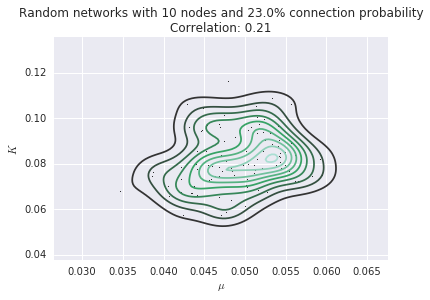

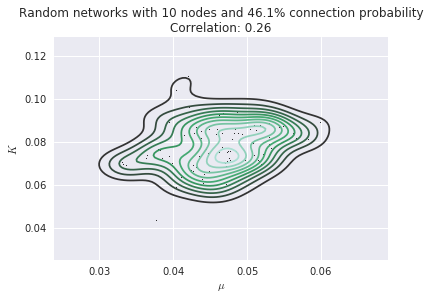

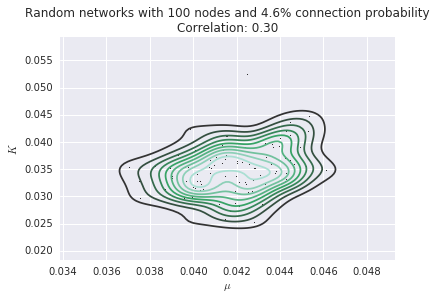

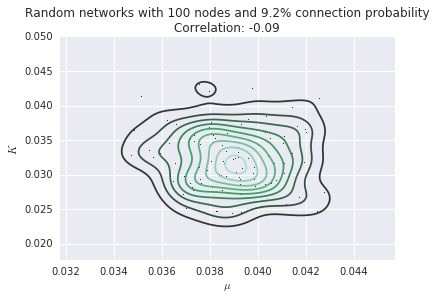

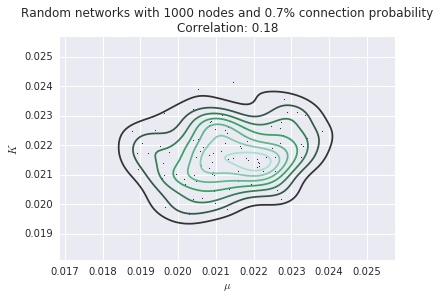

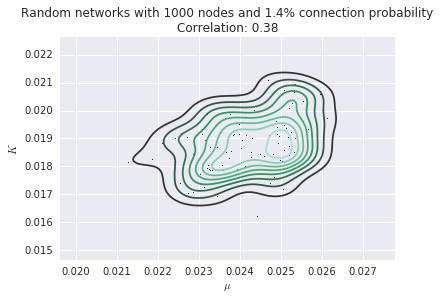

In [298]:
#### Using the possibly misspecified model of noise in both directions (is that actually a mispecification?) and autocorrelation (is that?) 
#### Using the same DSM each time 
def sample_mu_and_K_system(n_nodes=100,
                    p=.1,
                    n_iterations=1):
    mus = empty(n_iterations)
    Ks = empty(n_iterations)

    from igraph import Graph
    g = Graph.Erdos_Renyi(n_nodes, p, directed=True)
    costs = ones(g.vcount())

    for i in range(n_iterations):
        y = dsm_improvement(g,costs=costs)
        y = y[expspace_ind(y)]
        data = {'y':-diff(log(y)),
                'T':len(y)-1}
        fit = arma_model.sampling(data=data)
        mus[i] = fit['mu'].mean()
        Ks[i] = fit['K'].mean()
    return mus, Ks

n_iterations = 100

for n_nodes in [10,100,1000]:
    for p in [round(log(n_nodes)/n_nodes, 3),
              round(2*(log(n_nodes)/n_nodes), 3)]:
        print(n_nodes, p)
        mus, Ks = sample_mu_and_K_system(n_nodes=n_nodes, p=p, n_iterations=n_iterations)
        figure()
        sns.kdeplot(mus, Ks)
        xlabel(r'$\mu$')
        ylabel(r'$K$')
        scatter(mus, Ks, color='k', s=.5, label='Samples')
        title('Random networks with %i nodes and %.1f%% connection probability'
              '\nCorrelation: %.2f'%(n_nodes, p*100, pearsonr(mus,Ks)[0]))

10 0.23
10 0.461
100 0.046
100 0.092


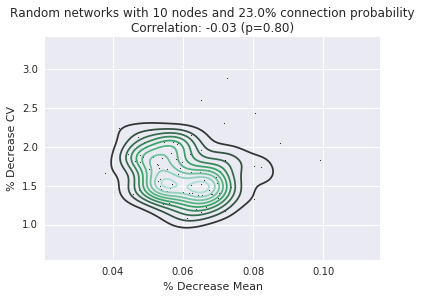

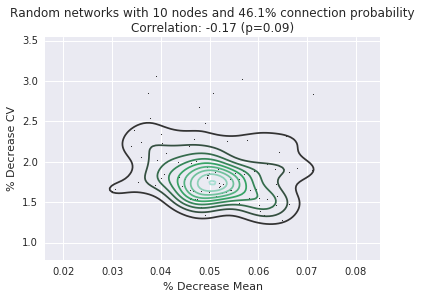

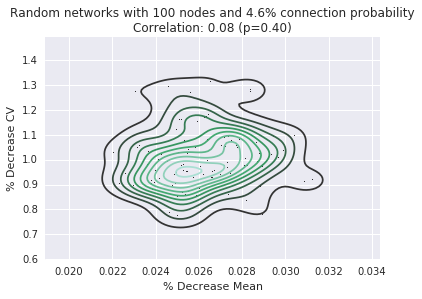

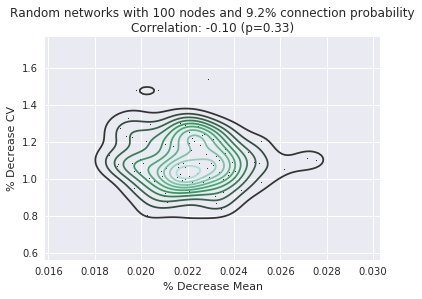

In [117]:
#### Using the possibly misspecified model of noise in both directions (is that actually a mispecification?) and autocorrelation (is that?) 
#### Using the same DSM each time, including inital costs

def sample_mean_and_cv_system(n_nodes=100,
                    p=.1,
                    n_iterations=1):
    means = empty(n_iterations)
    cvs = empty(n_iterations)

    from igraph import Graph
    g = Graph.Erdos_Renyi(n_nodes, p, directed=True)
    costs = rand_cost(g.vcount())
    
    for i in range(n_iterations):
        y = dsm_improvement(g,costs=costs)
        y = y[expspace_ind(y)]
        y = -diff(log(y))
        means[i] = y.mean()
        cvs[i] = y.std()/means[i]
    return means, cvs

n_iterations = 100

for n_nodes in [10,100]:
    for p in [round(log(n_nodes)/n_nodes, 3),
              round(2*(log(n_nodes)/n_nodes), 3)]:
        print(n_nodes, p)
        means, cvs = sample_mean_and_cv_system(n_nodes=n_nodes, p=p, n_iterations=n_iterations)
        
        x = means
        y = cvs
        figure()
        sns.kdeplot(x,y)
        xlabel(r'% Decrease Mean')
        ylabel(r'% Decrease CV')
        scatter(x,y, color='k', s=.5, label='Samples')
        title('Random networks with %i nodes and %.1f%% connection probability'
              '\nCorrelation: %.2f (p=%.2f)'%(n_nodes, p*100, pearsonr(x,y)[0], pearsonr(x,y)[1]))

10 0.23
10 0.461
100 0.046
100 0.092


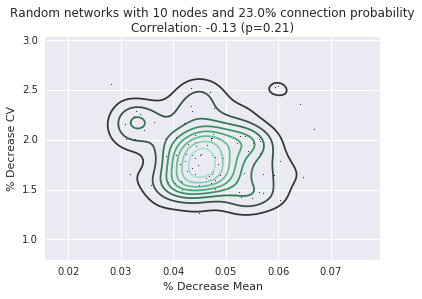

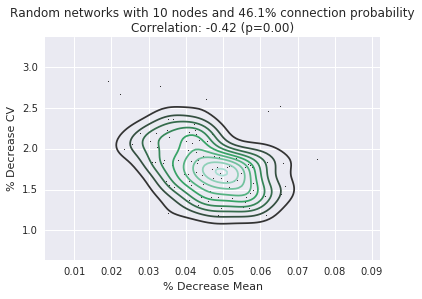

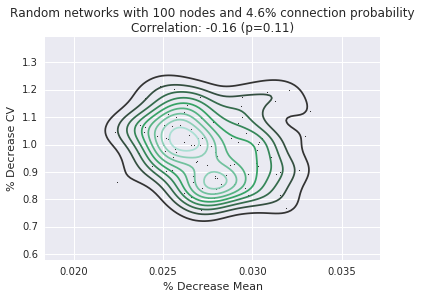

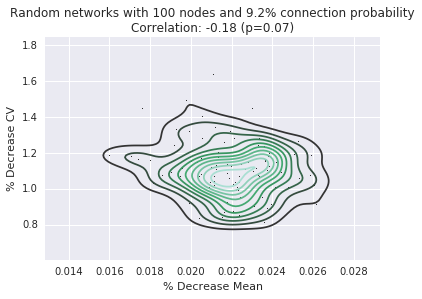

In [118]:
#### Using the possibly misspecified model of noise in both directions (is that actually a mispecification?) and autocorrelation (is that?) 
#### Using the same DSM each time, different inital costs

def sample_mean_and_cv_system(n_nodes=100,
                    p=.1,
                    n_iterations=1):
    means = empty(n_iterations)
    cvs = empty(n_iterations)

    from igraph import Graph
    g = Graph.Erdos_Renyi(n_nodes, p, directed=True)
    
    for i in range(n_iterations):
        y = dsm_improvement(g)
        y = y[expspace_ind(y)]
        y = -diff(log(y))
        means[i] = y.mean()
        cvs[i] = y.std()/means[i]
    return means, cvs

n_iterations = 100

for n_nodes in [10,100]:
    for p in [round(log(n_nodes)/n_nodes, 3),
              round(2*(log(n_nodes)/n_nodes), 3)]:
        print(n_nodes, p)
        means, cvs = sample_mean_and_cv_system(n_nodes=n_nodes, p=p, n_iterations=n_iterations)
        
        x = means
        y = cvs
        
        figure()
        sns.kdeplot(x,y)
        xlabel(r'% Decrease Mean')
        ylabel(r'% Decrease CV')
        scatter(x,y, color='k', s=.5, label='Samples')
        title('Random networks with %i nodes and %.1f%% connection probability'
              '\nCorrelation: %.2f (p=%.2f)'%(n_nodes, p*100, pearsonr(x,y)[0], pearsonr(x,y)[1]))

10 0.23
10 0.461
100 0.046
100 0.092
1000 0.007
1000 0.014


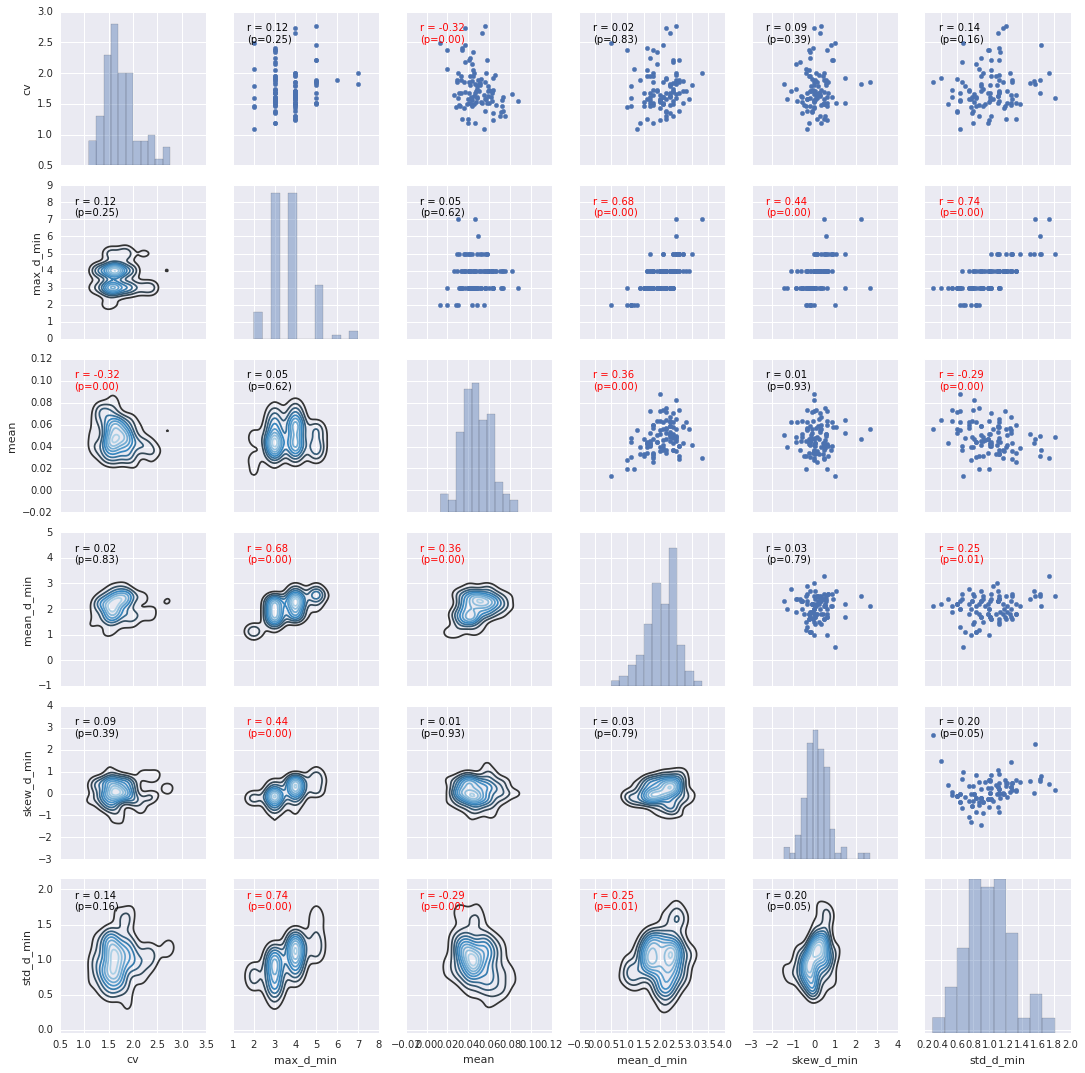

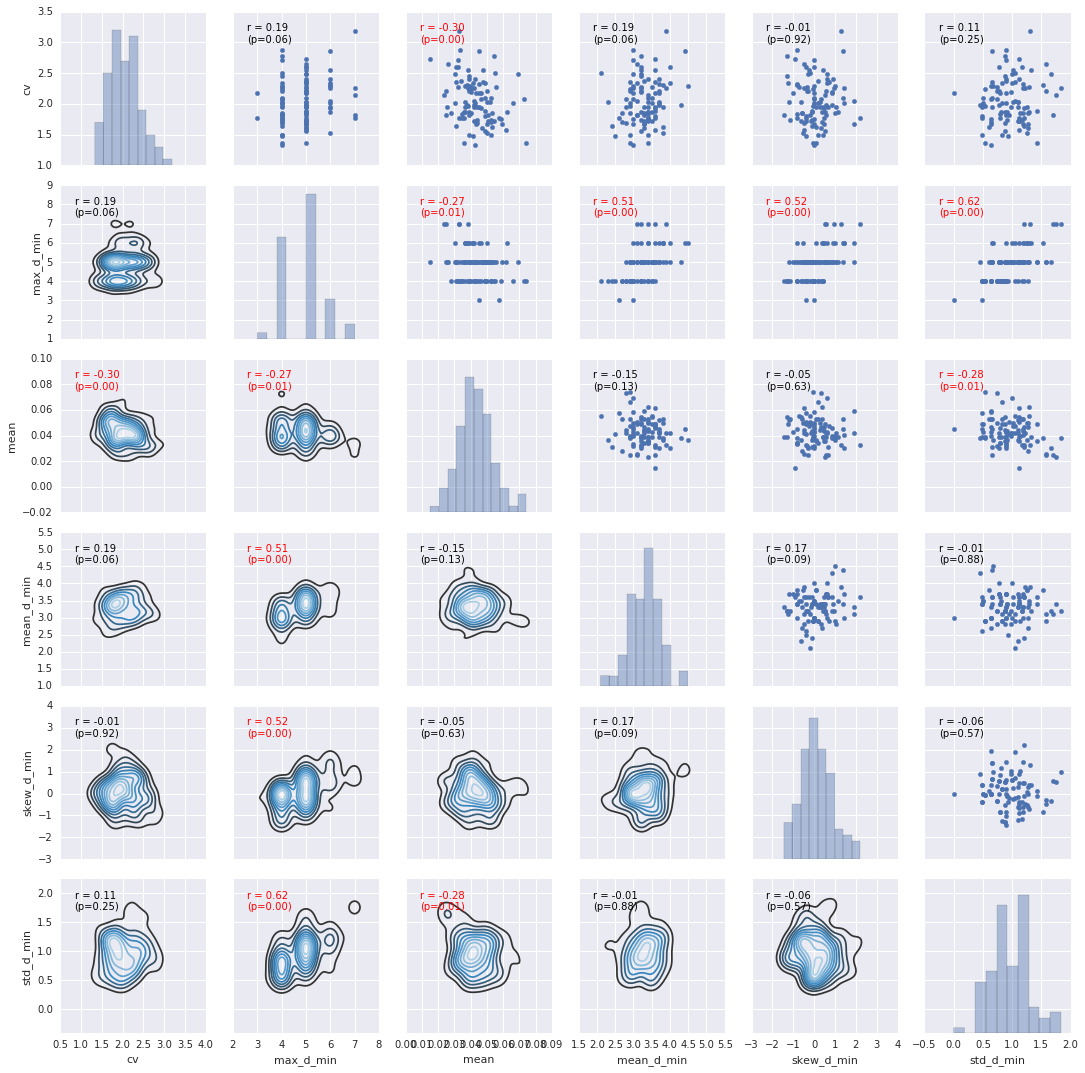

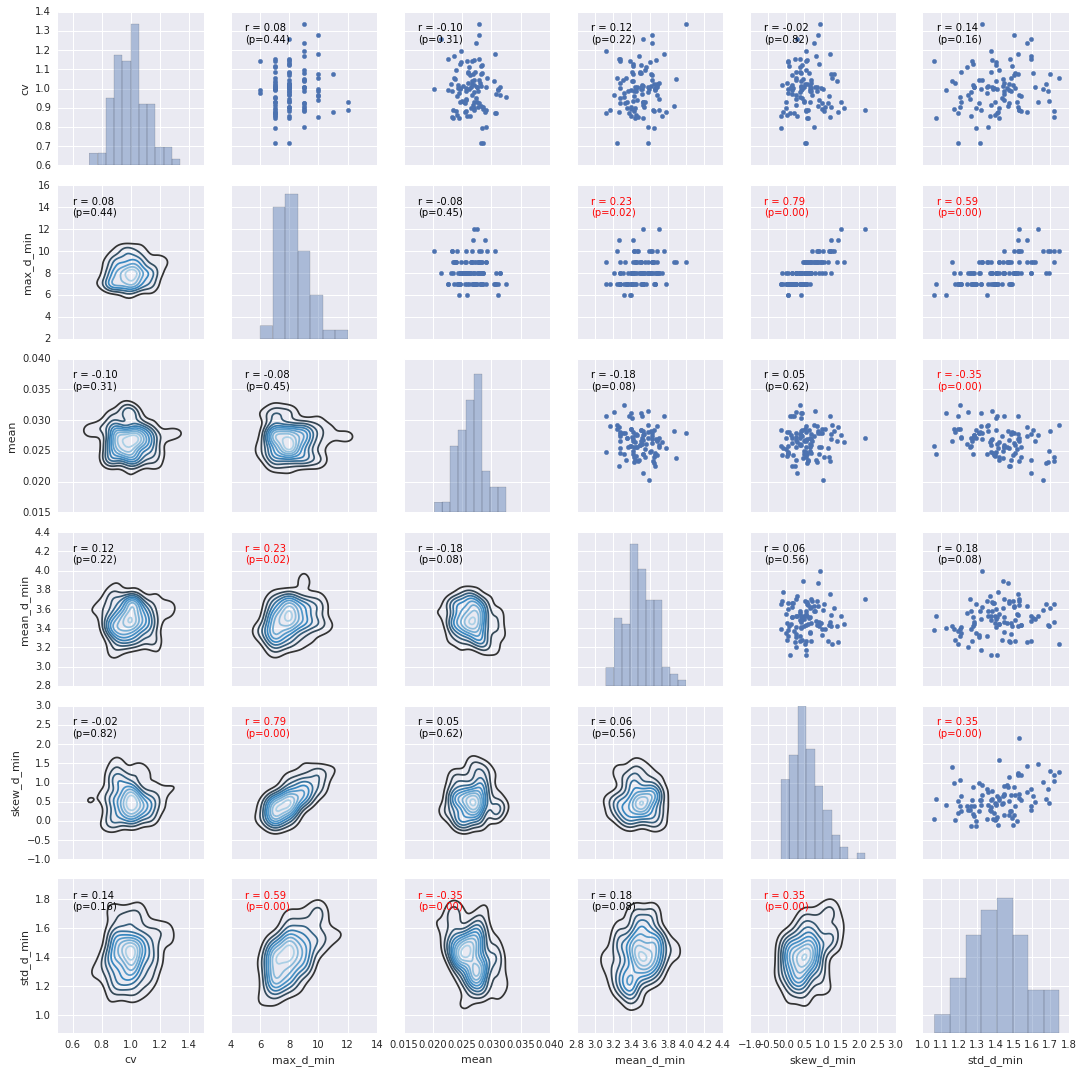

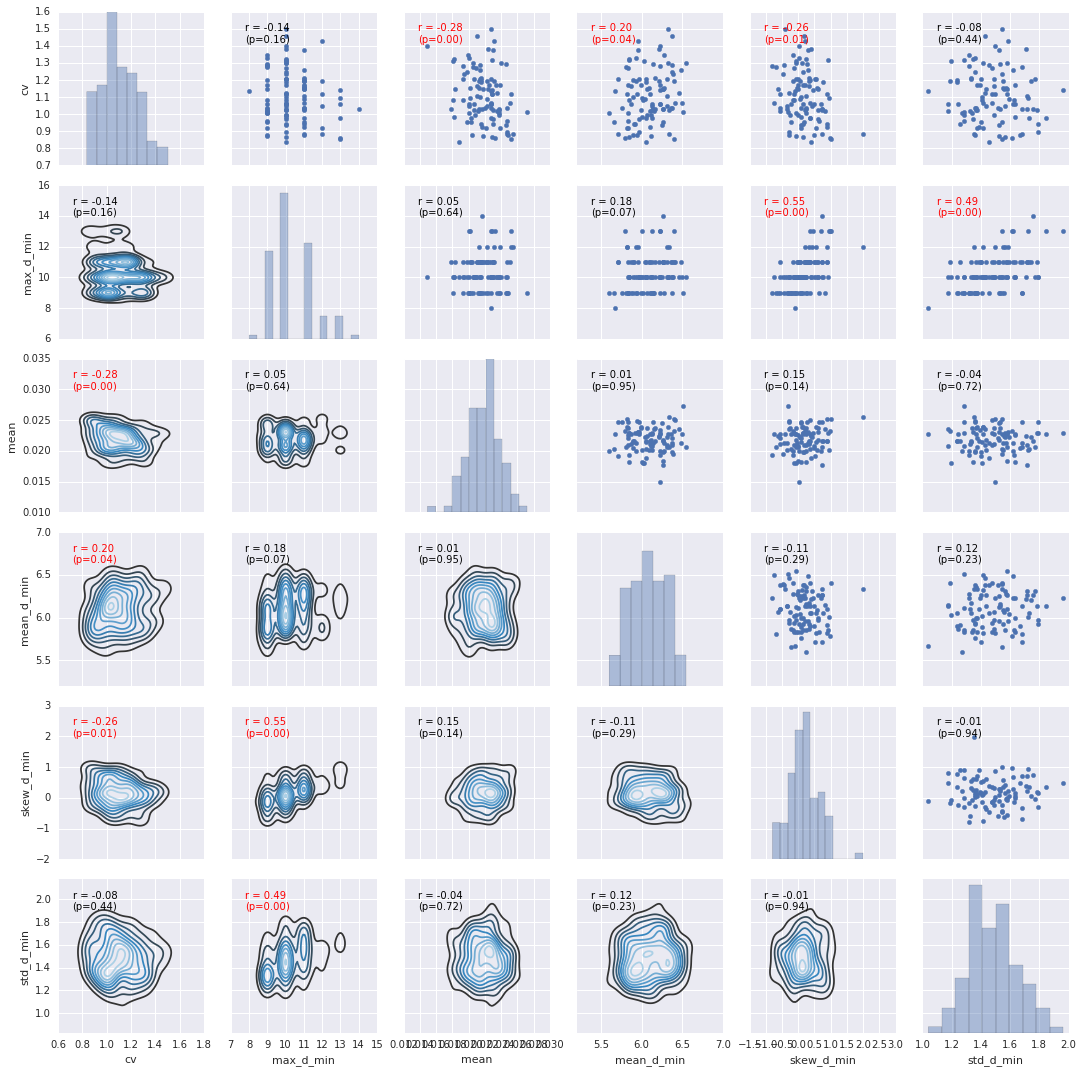

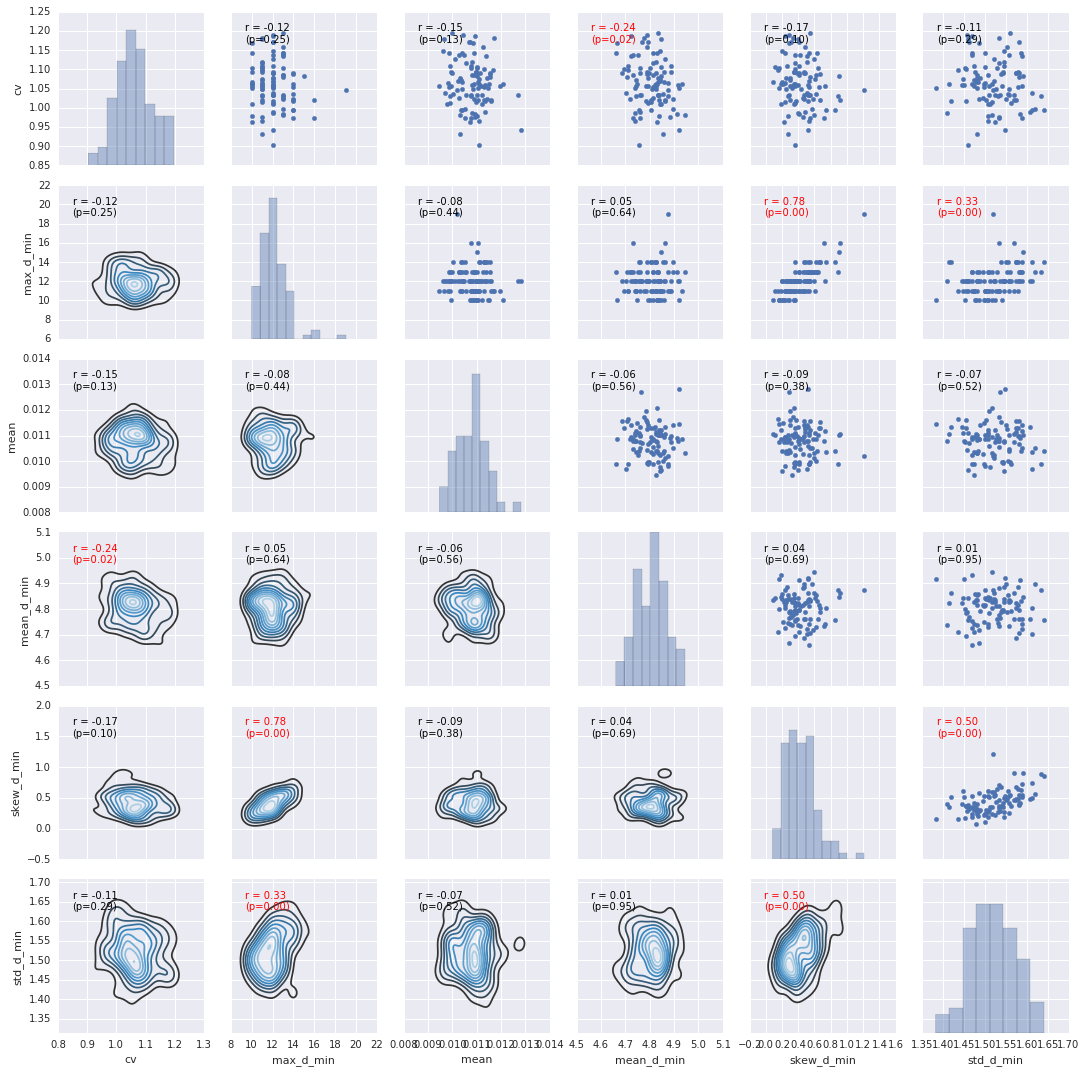

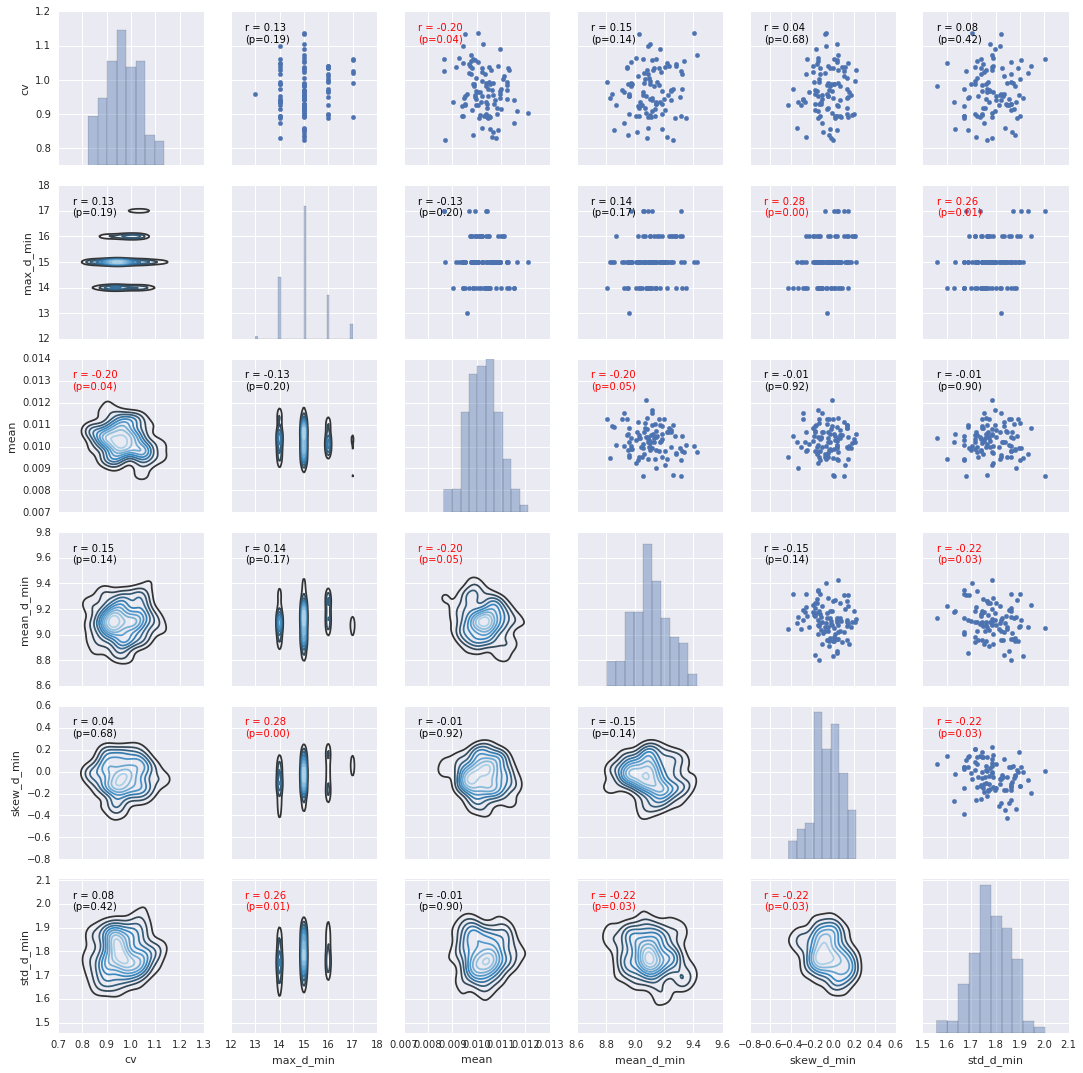

In [138]:
#Random initial costs
def sample_statistics(n_nodes=100,
                    p=.1,
                    n_iterations=1):
    means = empty(n_iterations)
    cvs = empty(n_iterations)
    max_d_mins = empty(n_iterations)
    mean_d_mins = empty(n_iterations)
    std_d_mins = empty(n_iterations)
    skew_d_mins = empty(n_iterations)

    from igraph import Graph
    for i in range(n_iterations):
        g = Graph.Erdos_Renyi(n_nodes, p, directed=True)
        max_d_mins[i], mean_d_mins[i], std_d_mins[i], skew_d_mins[i] = d_stats(g)
        y = dsm_improvement(g)
        y = y[expspace_ind(y)]
        y = -diff(log(y))
        means[i] = y.mean()
        cvs[i] = y.std()/means[i]
    return {'mean': means,
            'cv': cvs,
            'max_d_min': max_d_mins,
            'mean_d_min': mean_d_mins,
            'std_d_min': std_d_mins,
            'skew_d_min': skew_d_mins
            }

n_iterations = 100

for n_nodes in [10,100,1000]:
    for p in [round(log(n_nodes)/n_nodes, 3),
              round(2*(log(n_nodes)/n_nodes), 3)]:
        print(n_nodes, p)
        stats = pd.DataFrame(sample_statistics(n_nodes=n_nodes, p=p, n_iterations=n_iterations))
        fig = figure(figsize=(8,8))
        g = sns.PairGrid(stats, diag_sharey=False)
        g.map_lower(sns.kdeplot, cmap="Blues_d")
        g.map_upper(plt.scatter)
        g.map_diag(sns.distplot, kde=False)


        def corrfunc(x, y, **kws):
            r, p = pearsonr(x, y)
            ax = plt.gca()
            if p<.05:
                c='red'
            else:
                c='black'
            ax.annotate("r = {:.2f}\n(p={:.2f})".format(r,p),
                        xy=(.1, .8), xycoords=ax.transAxes,
                       color=c)
        g.map_lower(corrfunc)
        g.map_upper(corrfunc)
        
        
        fig.suptitle('Random networks with %i nodes and %.1f%% connection probability'
                     '\n%i samples.'%(n_nodes, p*100, n_iterations),y=1.02)

10 0.23
10 0.461
100 0.046
100 0.092
1000 0.007
1000 0.014


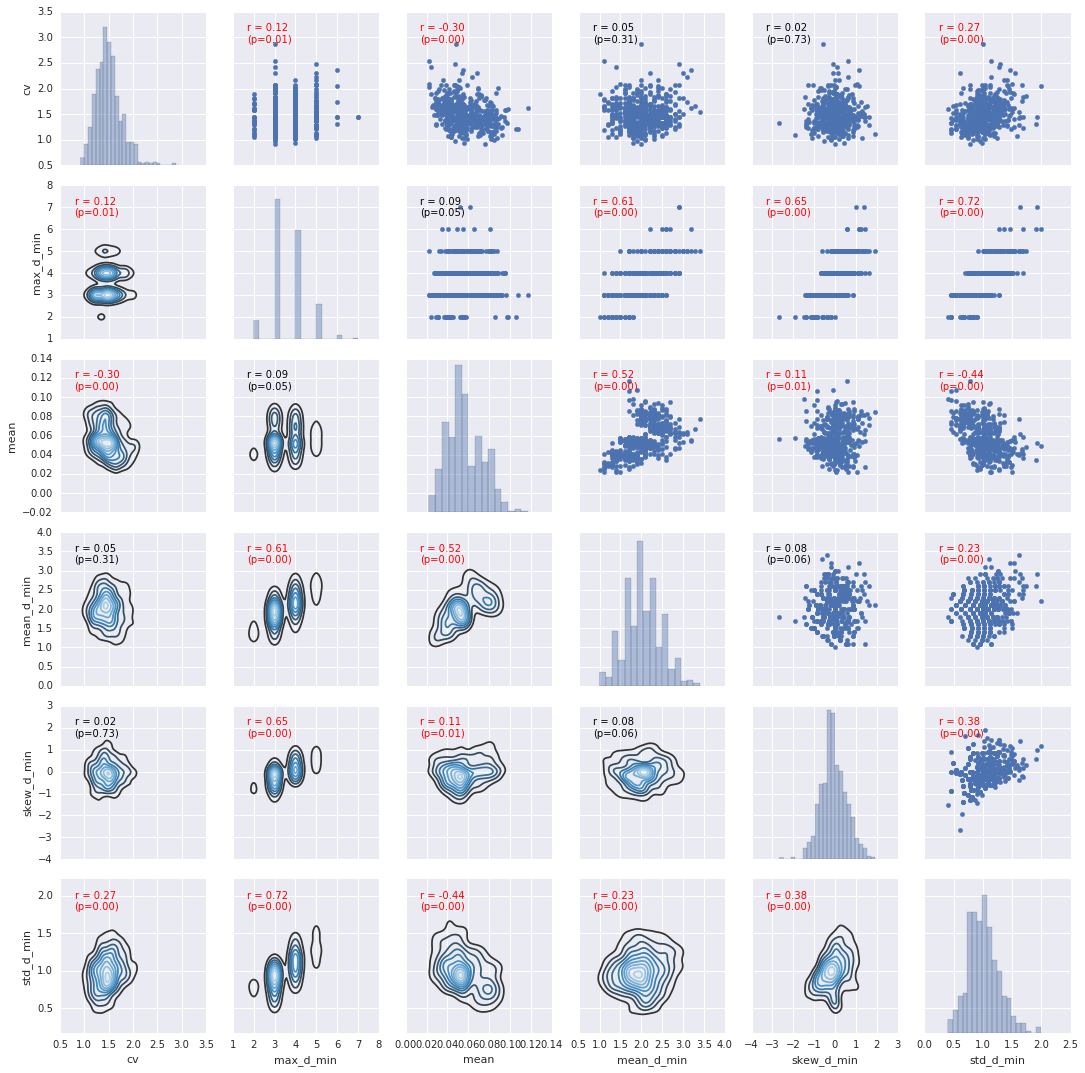

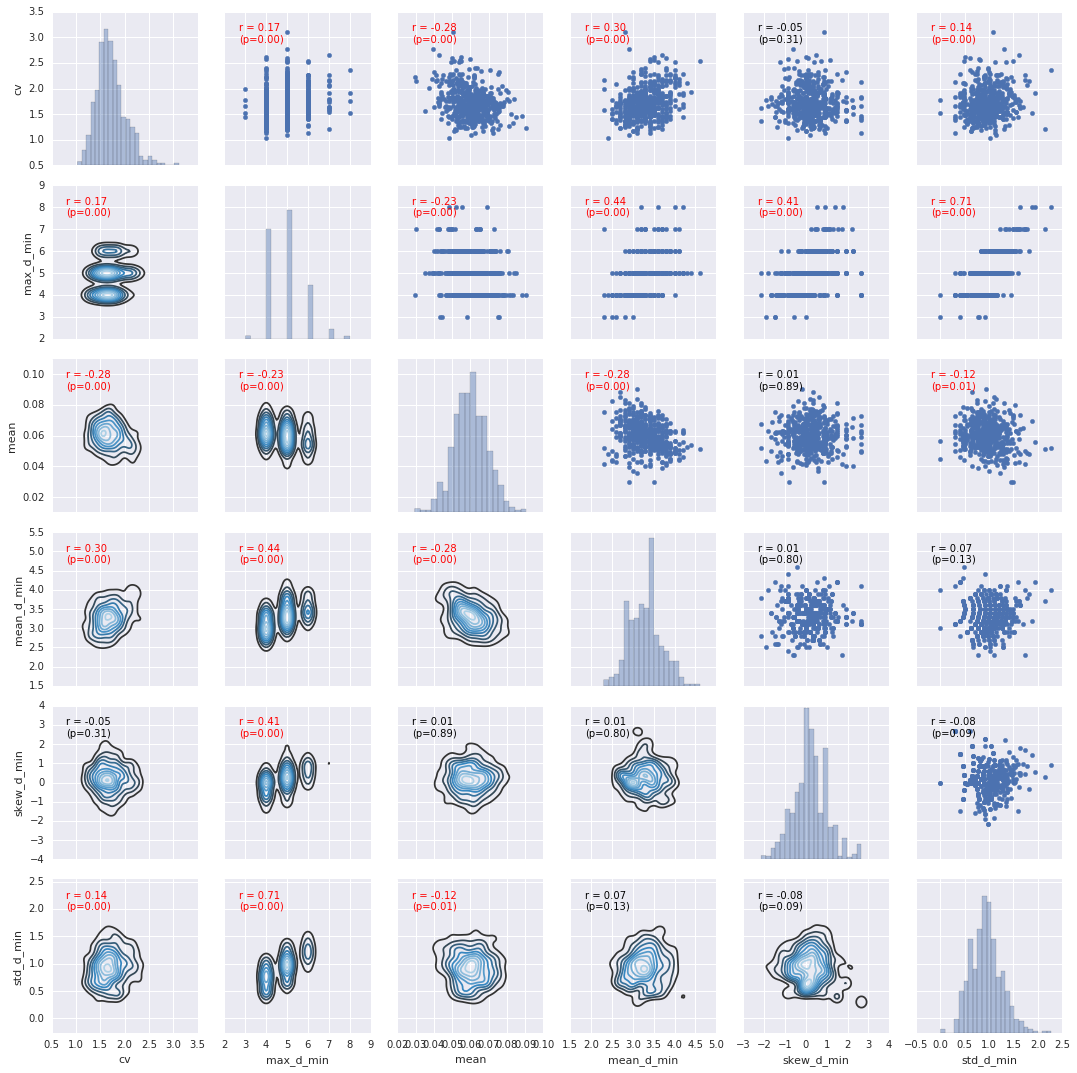

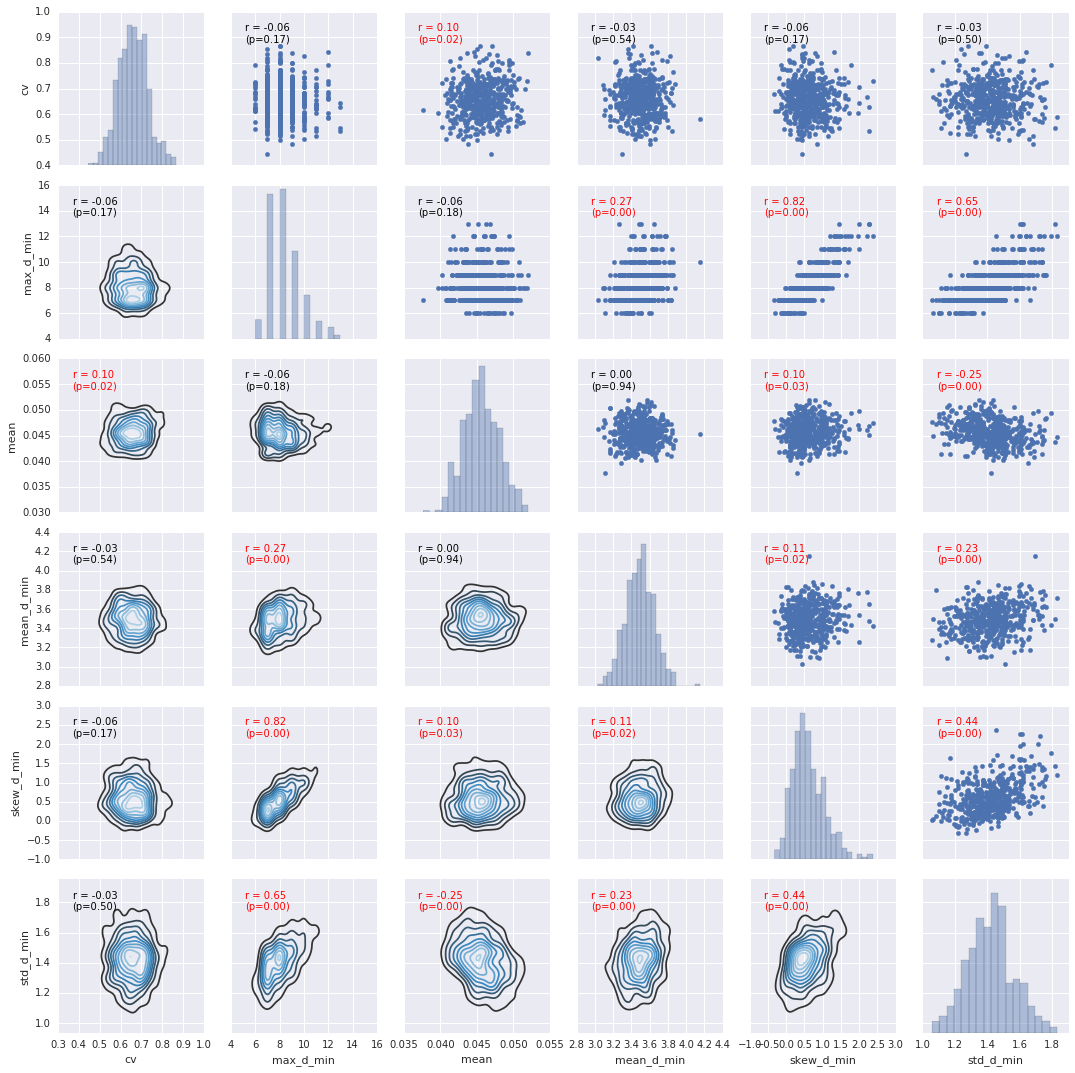

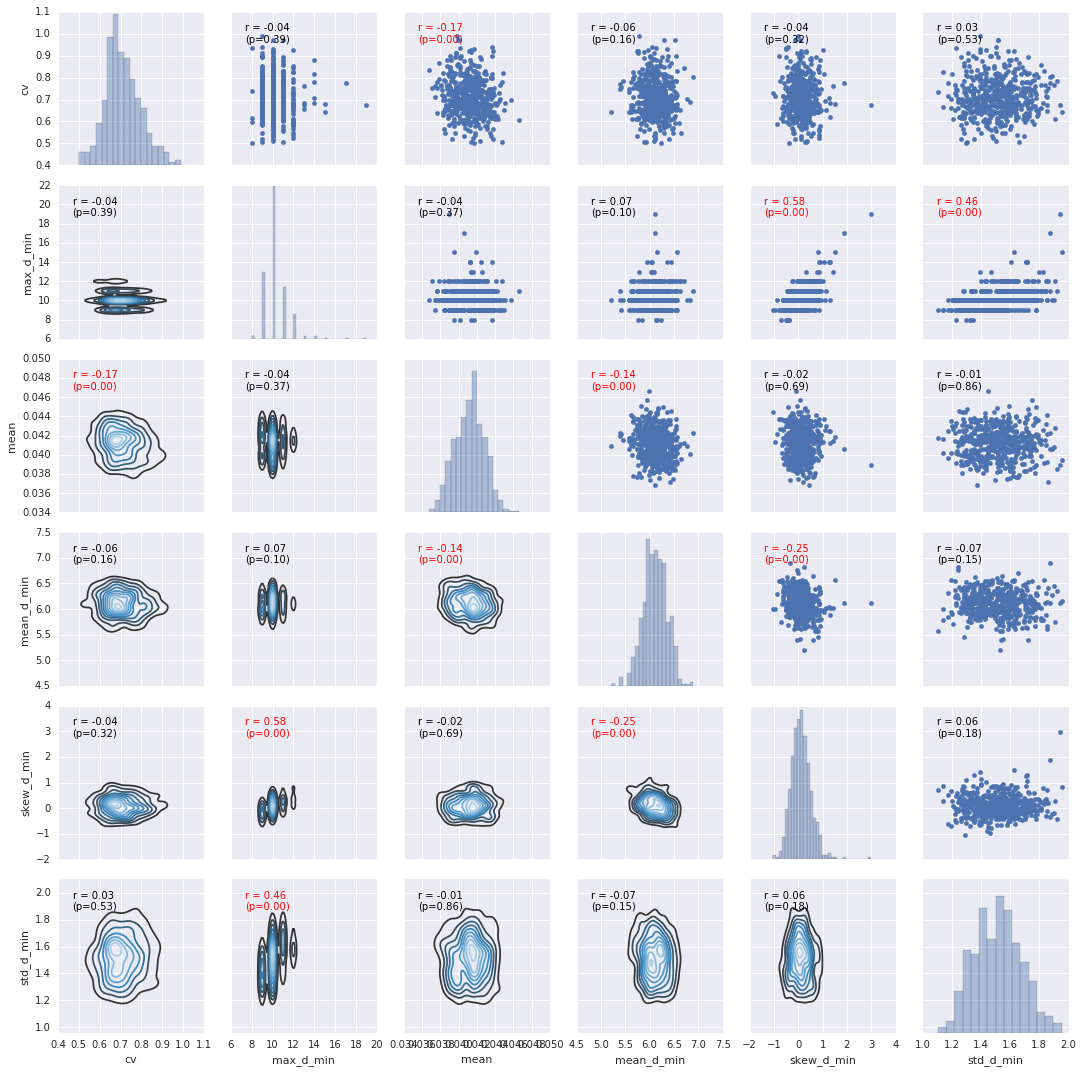

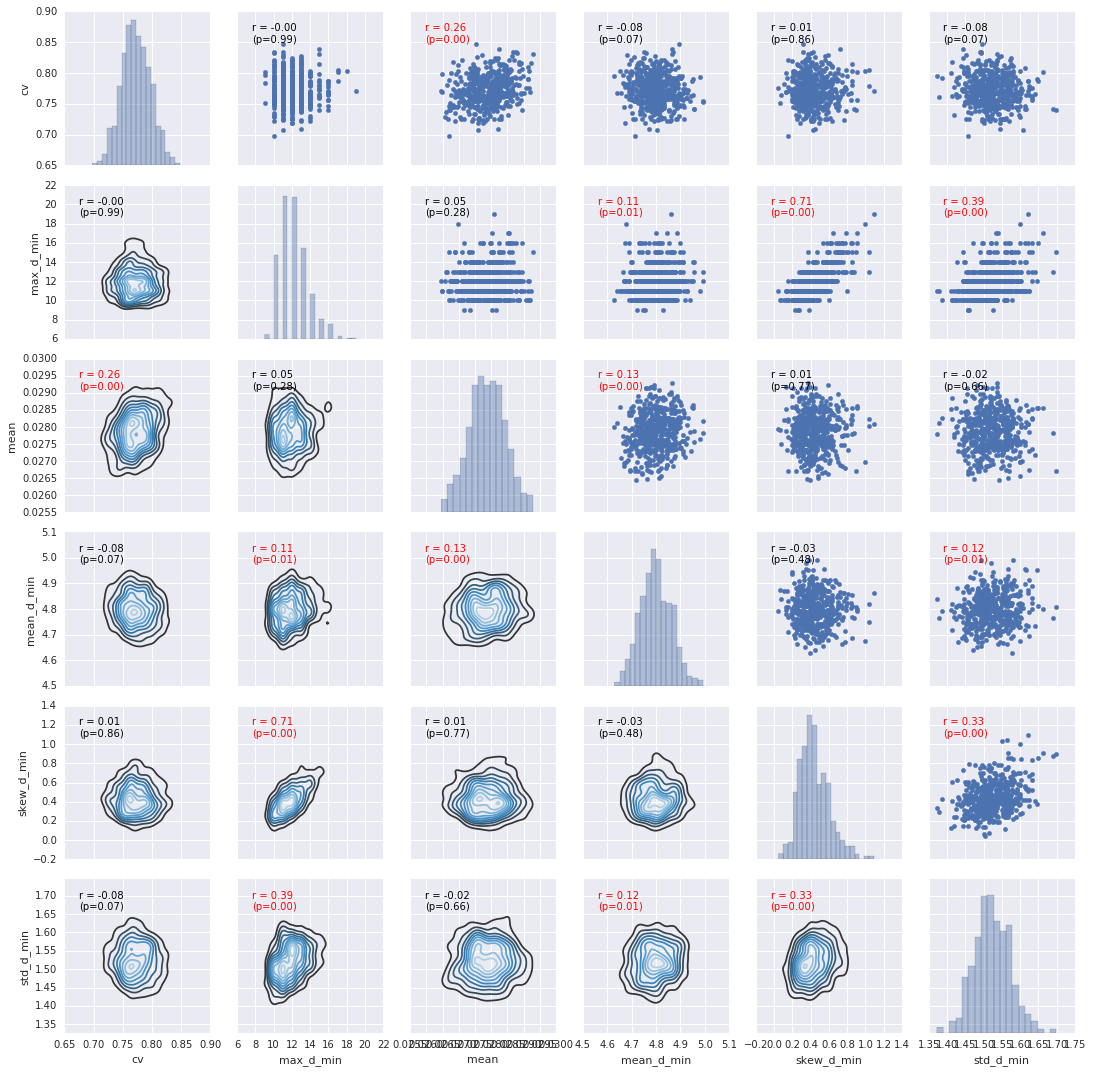

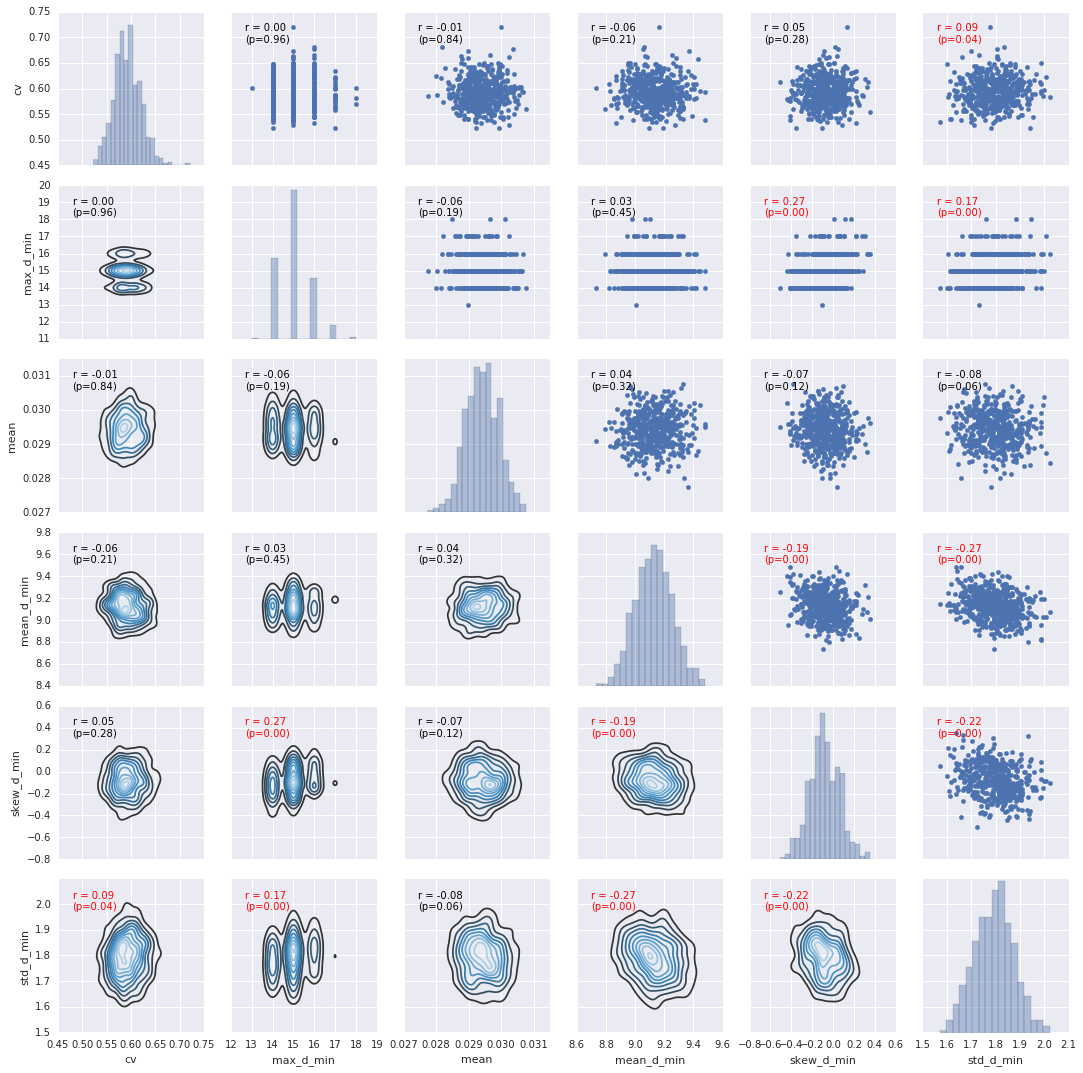

In [142]:
# All initial costs = 1
def sample_statistics(n_nodes=100,
                    p=.1,
                    n_iterations=1):
    means = empty(n_iterations)
    cvs = empty(n_iterations)
    max_d_mins = empty(n_iterations)
    mean_d_mins = empty(n_iterations)
    std_d_mins = empty(n_iterations)
    skew_d_mins = empty(n_iterations)

    from igraph import Graph
    for i in range(n_iterations):
        g = Graph.Erdos_Renyi(n_nodes, p, directed=True)
        g.add_edges(list(zip(range(g.vcount()),range(g.vcount()))))
        max_d_mins[i], mean_d_mins[i], std_d_mins[i], skew_d_mins[i] = d_stats(g)
        y = dsm_improvement(g,costs=ones(g.vcount()))
        y = y[expspace_ind(y)]
        y = -diff(log(y))
        means[i] = y.mean()
        cvs[i] = y.std()/means[i]
    return {'mean': means,
            'cv': cvs,
            'max_d_min': max_d_mins,
            'mean_d_min': mean_d_mins,
            'std_d_min': std_d_mins,
            'skew_d_min': skew_d_mins
            }

n_iterations = 500

for n_nodes in [10,100,1000]:
    for p in [round(log(n_nodes)/n_nodes, 3),
              round(2*(log(n_nodes)/n_nodes), 3)]:
        print(n_nodes, p)
        stats = pd.DataFrame(sample_statistics(n_nodes=n_nodes, p=p, n_iterations=n_iterations))
        fig = figure(figsize=(8,8))
        g = sns.PairGrid(stats, diag_sharey=False)
        g.map_lower(sns.kdeplot, cmap="Blues_d")
        g.map_upper(plt.scatter)
        g.map_diag(sns.distplot, kde=False)


        def corrfunc(x, y, **kws):
            r, p = pearsonr(x, y)
            ax = plt.gca()
            if p<.05:
                c='red'
            else:
                c='black'
            ax.annotate("r = {:.2f}\n(p={:.2f})".format(r,p),
                        xy=(.1, .8), xycoords=ax.transAxes,
                       color=c)
        g.map_lower(corrfunc)
        g.map_upper(corrfunc)
     
        fig.suptitle('Random networks with %i nodes and %.1f%% connection probability'
                     '\n%i samples.'%(n_nodes, p*100, n_iterations),y=.98)

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(-0.14724539026488639, 2.9253325135033521e-06)


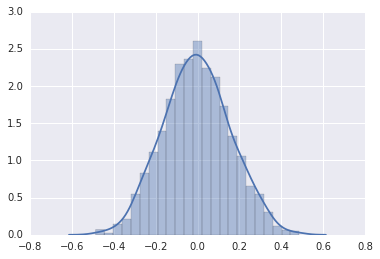

In [285]:
n_nodes = 100
p = round(2*(log(n_nodes)/n_nodes), 3)
g = Graph.Erdos_Renyi(n_nodes, p, directed=True)
g.add_edges(list(zip(range(g.vcount()),range(g.vcount()))))
costs = ones(g.vcount())
n_iterations = 1000

means = empty(n_iterations)
cvs = empty(n_iterations)
rs = empty(n_iterations)
for i in range(n_iterations):
    y = dsm_improvement(g,costs=costs)
    y = y[expspace_ind(y)]
    y = -diff(log(y))
    means[i] = y.mean()
    cvs[i] = y.std()/means[i]
    rs[i] = pearsonr(y[:-1], y[1:])[0]
pearsonr(means,cvs)
sns.distplot(rs)
print(pearsonr(means,cvs))

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(-0.015447163613967203, 0.62562041992695683)


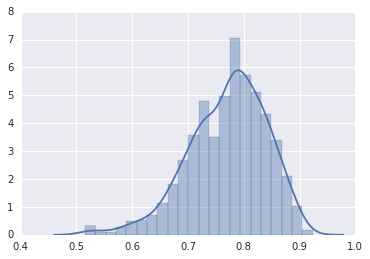

In [286]:
n_nodes = 1000
p = round(2*(log(n_nodes)/n_nodes), 3)
g = Graph.Erdos_Renyi(n_nodes, p, directed=True)
g.add_edges(list(zip(range(g.vcount()),range(g.vcount()))))
costs = ones(g.vcount())
n_iterations = 1000

means = empty(n_iterations)
cvs = empty(n_iterations)
rs = empty(n_iterations)
for i in range(n_iterations):
    y = dsm_improvement(g,costs=costs)
    y = y[expspace_ind(y)]
    y = -diff(log(y))
    means[i] = y.mean()
    cvs[i] = y.std()/means[i]
    rs[i] = pearsonr(y[:-1], y[1:])[0]
pearsonr(means,cvs)
sns.distplot(rs)
print(pearsonr(means,cvs))

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


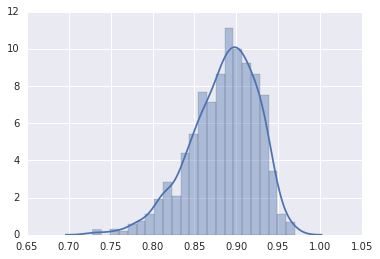

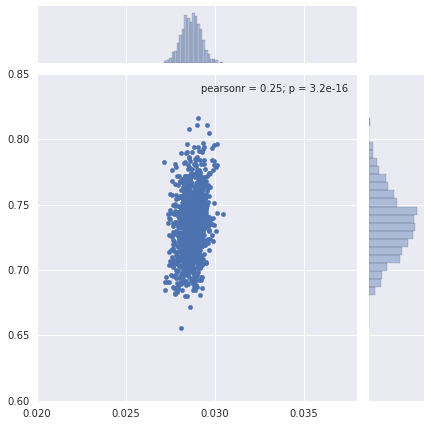

In [292]:
n_nodes = 1000
p = round((log(n_nodes)/n_nodes), 3)
g = Graph.Erdos_Renyi(n_nodes, p, directed=True)
g.add_edges(list(zip(range(g.vcount()),range(g.vcount()))))
costs = ones(g.vcount())
n_iterations = 1000

means = empty(n_iterations)
cvs = empty(n_iterations)
rs = empty(n_iterations)
for i in range(n_iterations):
    y = dsm_improvement(g,costs=costs)
    y = y[expspace_ind(y)]
    y = -diff(log(y))
    means[i] = y.mean()
    cvs[i] = y.std()/means[i]
    rs[i] = pearsonr(y[:-1], y[1:])[0]
pearsonr(means,cvs)
sns.distplot(rs)
sns.jointplot(means,cvs)

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


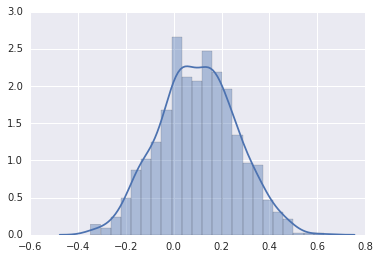

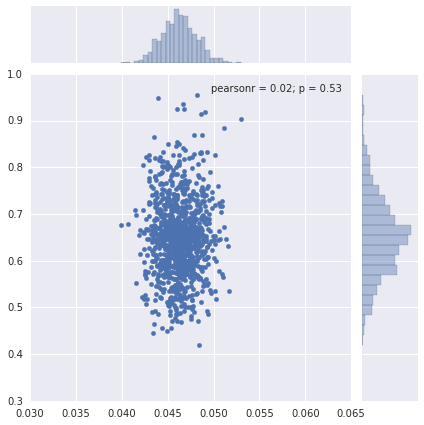

In [293]:
n_nodes = 100
p = round((log(n_nodes)/n_nodes), 3)
g = Graph.Erdos_Renyi(n_nodes, p, directed=True)
g.add_edges(list(zip(range(g.vcount()),range(g.vcount()))))
costs = ones(g.vcount())
n_iterations = 1000

means = empty(n_iterations)
cvs = empty(n_iterations)
rs = empty(n_iterations)
for i in range(n_iterations):
    y = dsm_improvement(g,costs=costs)
    y = y[expspace_ind(y)]
    y = -diff(log(y))
    means[i] = y.mean()
    cvs[i] = y.std()/means[i]
    rs[i] = pearsonr(y[:-1], y[1:])[0]
pearsonr(means,cvs)
sns.distplot(rs)
sns.jointplot(means,cvs)

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


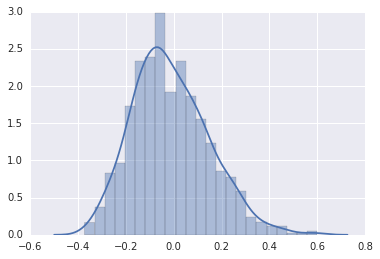

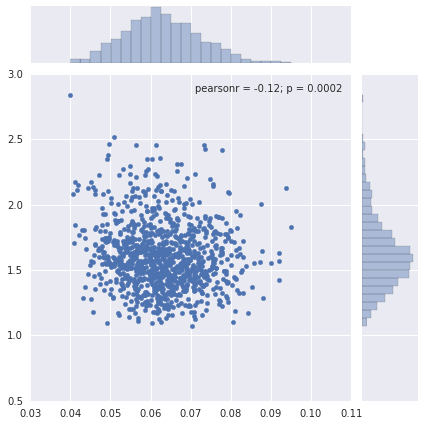

In [294]:
n_nodes = 10
p = round((log(n_nodes)/n_nodes), 3)
g = Graph.Erdos_Renyi(n_nodes, p, directed=True)
g.add_edges(list(zip(range(g.vcount()),range(g.vcount()))))
costs = ones(g.vcount())
n_iterations = 1000

means = empty(n_iterations)
cvs = empty(n_iterations)
rs = empty(n_iterations)
for i in range(n_iterations):
    y = dsm_improvement(g,costs=costs)
    y = y[expspace_ind(y)]
    y = -diff(log(y))
    means[i] = y.mean()
    cvs[i] = y.std()/means[i]
    rs[i] = pearsonr(y[:-1], y[1:])[0]
pearsonr(means,cvs)
sns.distplot(rs)
sns.jointplot(means,cvs)

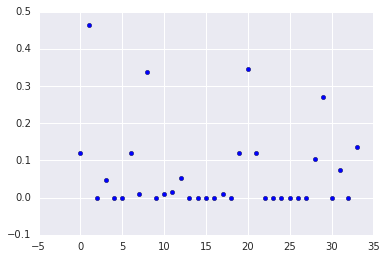

In [297]:
df = pd.DataFrame(columns=['n', 'p', 'mean_degree',
                            'max_d_min', 'mean_d_min', 'std_d_min', 'skew_d_min']
                   )
n_iterations = 1000
ns = []
ps = []
max_d_mins = []
mean_d_mins = [] 
std_d_mins = []
skew_d_mins = []

for n_nodes in [10,100,1000]:
    for p in [round(log(n_nodes)/n_nodes, 3),
              round(2*(log(n_nodes)/n_nodes), 3)]:
        for i in range(n_iterations):
            max_d_mins[i], mean_d_mins[i], std_d_mins[i], skew_d_mins[i] = d_stats(g)


In [ ]:
def sample_mu_and_K_components(n_nodes=100,
                    p=.1,
                    n_iterations=1):
    mus = []
    Ks = []

    from igraph import Graph
    for i in range(n_iterations):
        g = Graph.Erdos_Renyi(n_nodes, p, directed=True)
        y = dsm_improvement(g,n_attempts=1000,components=True)
        y = y[expspace_ind(y)]
        for n in range(n_nodes):
            data = {'y':-diff(log(y[:,n])),
                    'T':len(y)-1}
            fit = arma_model.sampling(data=data)
            mus.append(fit['mu'].mean())
            Ks.append(fit['K'].mean())
    return array(mus), array(Ks)

n_iterations = 100

for n_nodes in [10,100,1000]:
    for p in [round(log(n_nodes)/n_nodes, 3),
              round(2*(log(n_nodes)/n_nodes), 3)]:
        print(n_nodes, p)
        mus, Ks = sample_mu_and_K_components(n_nodes=n_nodes, p=p, n_iterations=n_iterations)
        figure()
        sns.kdeplot(mus, Ks)
        xlabel(r'$\mu$')
        ylabel(r'$K$')
        scatter(mus, Ks, color='k', s=.5, label='Samples')
        title('Random networks with %i nodes and %.1f%% connection probability'
              '\nCorrelation: %.2f'%(n_nodes, p*100, pearsonr(mus,Ks)[0]))        
        figure()
        sns.kdeplot(mus[mus>.01], Ks[mus>.01])
        xlabel(r'$\mu$')
        ylabel(r'$K$')
        scatter(mus, Ks, color='k', s=.5, label='Samples')
        title('Random networks with %i nodes and %.1f%% connection probability'
              '\nCorrelation: %.2f'%(n_nodes, p*100, pearsonr(mus,Ks)[0]))